In [1]:
%matplotlib inline


In [6]:
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from astropy.time import Time
import glob
import re
from astropy.table import Table
import astropy.table as at
import astropy
import numpy as np
import extinction

In [4]:
matplotlib.rcParams['figure.figsize']      = [15, 5]
matplotlib.rcParams['image.origin']        = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['image.cmap']          = 'inferno'
matplotlib.rcParams['image.aspect']        = 'auto'

In [7]:
spec_log = Table(names = ['phase', 'name', 'file'], dtype = ['i4', 'U8', 'U64'])
for folder in glob.glob('./reduced_spectra/*'):
    objname = folder.split('/')[2]
    f_list = glob.glob(folder+'/*')
#    obj_dict = {}
    for df in f_list:
        t = int(re.findall(r'd\d+', df)[0][1:])
#        obj_dict[t] = df
        spec_log.add_row([t, objname, df])
#    f_dict[objname] = obj_dict
spec_log.sort('phase')

z_dict = {'2010jl':0.0107,
          '2005ip':0.0072,
          '2020aekp':0.046,
          '2020nxt':0.023,
          '1998S':0.003, 
          '2011fe':0.0008,
          '2015G': 0.0045,
          '2021csp':0.083,
          '2017egm':0.030721,
          '2020fqv':0.007522}

type_dict = {'2010jl':'IIn',
          '2005ip':'IIn',
          '2020aekp':'Ia-CSM',
          '2020nxt':'Ibn',
          '1998S':'IIn', 
          '2011fe':'Ia',
          '2015G': 'Ibn',
          '2021csp':'Icn',
          '2017egm':'SLSN-I',
          '2020fqv':'Ia'}

In [ ]:
xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']


In [16]:
from numpy import polyfit, poly1d
from scipy.integrate import simps
def calc_emflux(wav, flux, wav_up, wav_low):
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    p = polyfit(np.array([wav[low_ind-1],wav[low_ind],wav[low_ind+1],wav[up_ind-1],wav[up_ind],wav[up_ind+1]]), 
               np.array([flux[low_ind-1],flux[low_ind],flux[low_ind+1],flux[up_ind-1],flux[up_ind],flux[up_ind+1]]),
               deg = 1)
    continuum = poly1d(p)
    emflux = simps(flux[ind]-continuum(wav[ind]), wav[ind])
    return emflux

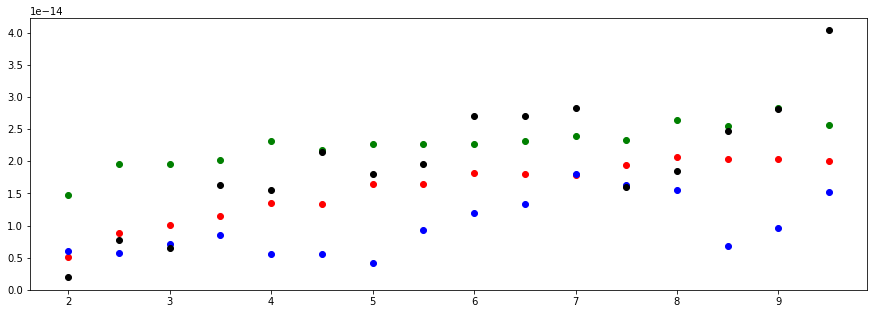

In [21]:
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits')
z = z_dict['2005ip']
ebv = 0.047
a_v = 3.1*ebv

for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up = 1242.8+bound
    wav_low = 1238.8-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)
    plt.scatter(bound, emflux,color ='r')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up =  1486.5+bound
    wav_low = 1483.3-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/2.72
    plt.scatter(bound, emflux,color ='g')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up =  1550.7+bound
    wav_low = 1548.2-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/1.14
    plt.scatter(bound, emflux,color ='b')
    
for bound in np.arange(2., 10., 0.5):
    wav = spec[1].data['WAVELENGTH'][0]/(1+z)
    flux = spec[1].data['FLUX'][0]
    wav_up = 1640.4+bound
    wav_low = 1640.4-bound
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low)*10**(extinc/2.5)*4.8/0.88
    plt.scatter(bound, emflux,color ='k')

In [92]:
def calc_emflux(wav, flux, wav_up, wav_low, cont_bound = 1):
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    p = polyfit(np.append(wav[low_ind-cont_bound:low_ind+cont_bound+1],wav[up_ind-cont_bound:up_ind+1+cont_bound]), 
                   np.append(flux[low_ind-cont_bound:low_ind+cont_bound+1],flux[up_ind-cont_bound:up_ind+1+cont_bound]),
                   deg = 1)
    continuum = poly1d(p)
    emflux = simps(flux[ind]-continuum(wav[ind]), wav[ind])
    return emflux

def plot_region(ax, wav, flux, linewaves, linename = None, bound = 6, xlim =5, ylim = 5e-15,cont_bound = 3):
    
    wav_up =  max(linewaves)+bound
    wav_low = min(linewaves)-bound
    ind = (wav>wav_low)&(wav<wav_up)
    x = np.arange(len(wav))
    up_ind = max(x[ind])
    low_ind = min(x[ind])
    
    p = polyfit(np.append(wav[low_ind-cont_bound:low_ind+cont_bound+1],wav[up_ind-cont_bound:up_ind+1+cont_bound]), 
                   np.append(flux[low_ind-cont_bound:low_ind+cont_bound+1],flux[up_ind-cont_bound:up_ind+1+cont_bound]),
                   deg = 1)
    continuum = poly1d(p)
    x = np.arange(wav_low-1, wav_up+1)
    ax.text(wav_up, ylim/5*4,linename)
    ax.plot(x,continuum(x))
    ax.plot(wav, flux, marker = 'o')
    ax.set_xlim(wav_low-xlim, wav_up+xlim)
    ax.set_ylim(-ylim/10, ylim)
    for line in linewaves:
        ax.axvline(line, linestyle = ':')
    extinc = extinction.fitzpatrick99(np.array([wav_up,wav_low]), a_v, 3.1)[0]
    emflux = calc_emflux(wav, flux, wav_up, wav_low, cont_bound = cont_bound)*10**(extinc/2.5)
    ax.text(wav_up-3, ylim/10*7,'line flux = {:.2f}'.format(emflux*1e15)+r' $\times 10^{-15}$  erg/s/cm^2')
    return emflux

## 2005ip

In [115]:
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits')
z = z_dict['2005ip']
ebv = 0.047
a_v = 3.1*ebv

1.9151404480675936e-14
1.3134134802374678e-14 2.3177884945367076e-14
4.5258672001646195e-15 1.9056282948061556e-14
4.600968037947587e-15 2.5096189297895928e-14


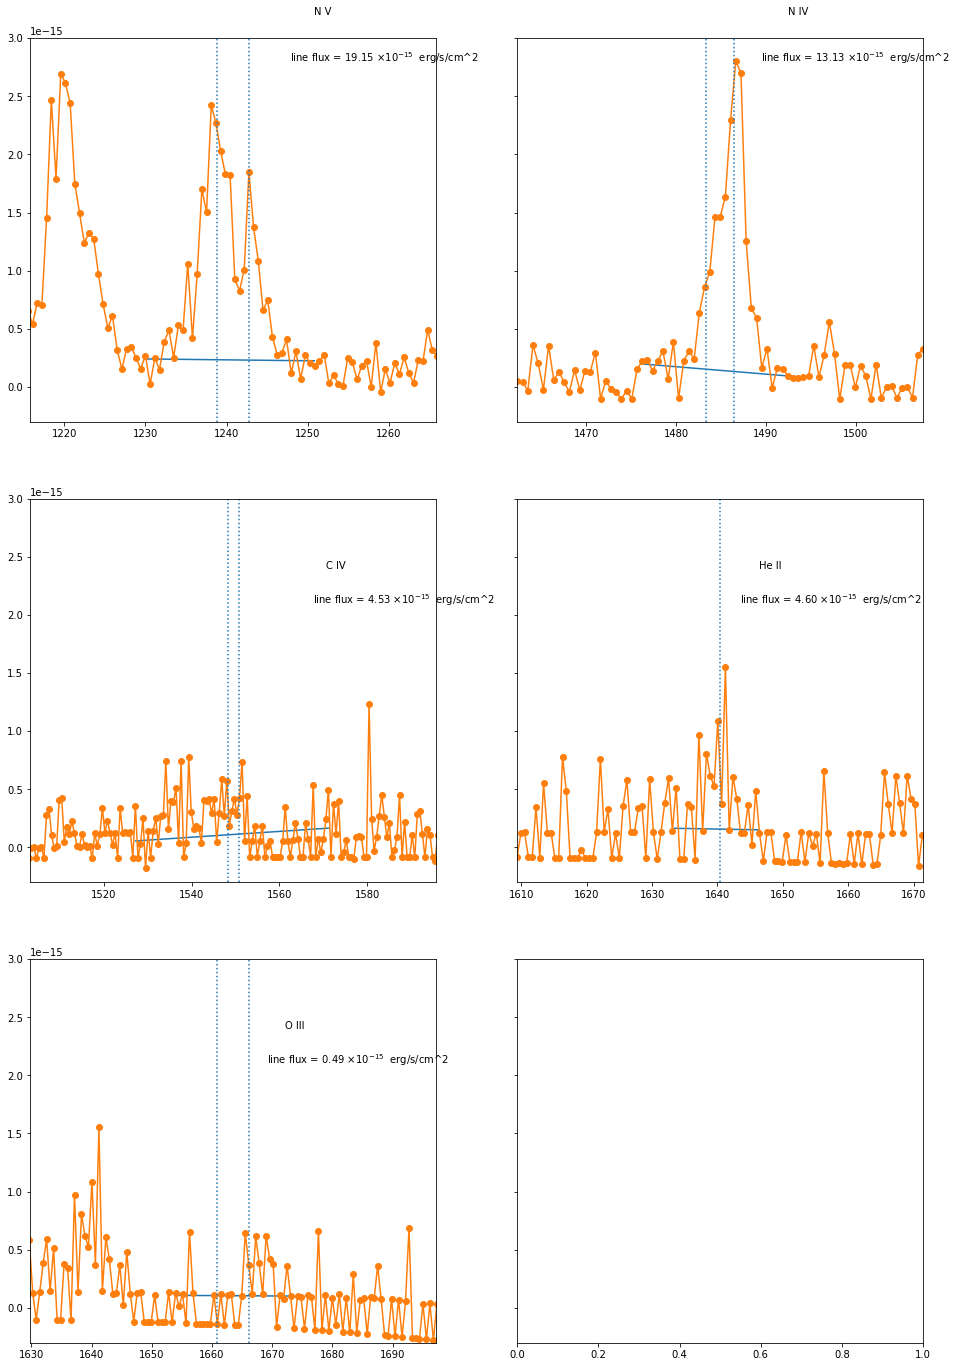

In [116]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

ebv = 0.047
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]
bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)



In [118]:
spec = fits.open('./reduced_spectra/2005ip/2005ip_d3042NUV_x1d.fits')
z = z_dict['2005ip']
ebv = 0.047
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]


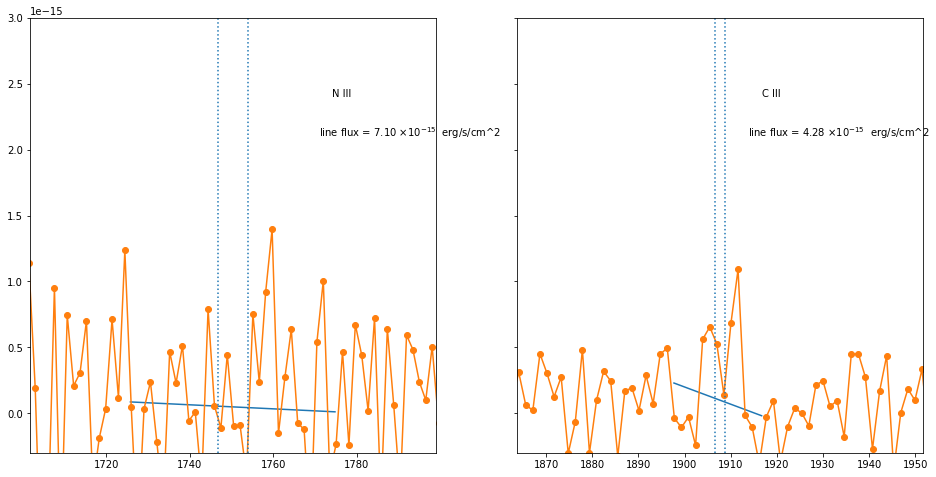

In [122]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 20
emflux = plot_region(axes[0], wav, flux, [ 1746.8,1754.0], linename = 'N III', bound = bound, 
                     xlim =25, ylim = 3e-15)

bound = 8
emflux = plot_region(axes[1], wav, flux, [ 1906.7, 1908.7], linename = 'C III', bound = bound, 
                     xlim =35, ylim = 3e-15)

## 2021csp

(948.9300281581945, 2158.4418827675104)

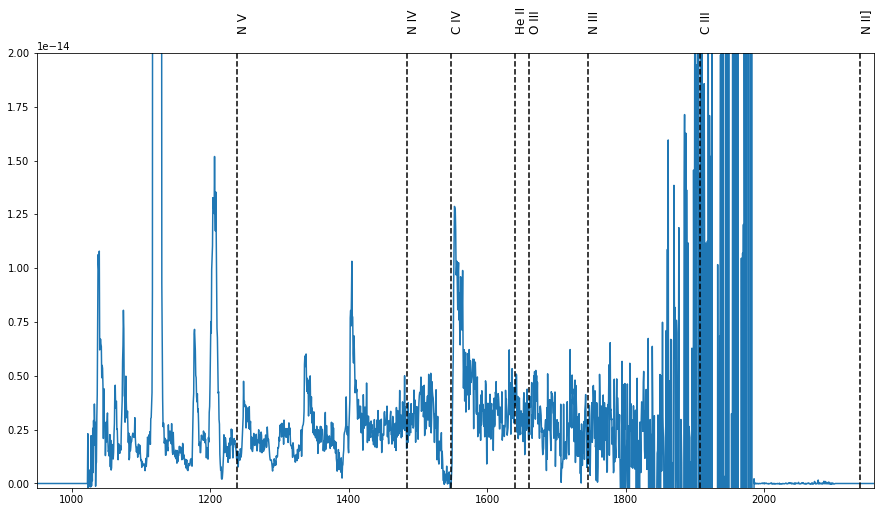

In [134]:
spec = fits.open('./reduced_spectra/2021csp/2021csp_d8FUV.fits')
z = z_dict['2021csp']
ebv = 0.028
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
bin_size=8
f_bin = np.zeros(int(len(wav)/bin_size))
wav_bin = np.zeros(int(len(wav)/bin_size))
for i in range(int(len(wav)/bin_size)):
    wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
    f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])

plt.plot(wav_bin, f_bin)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-14,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-14)
plt.xlim(min(wav), max(wav))

-3.832071157065507e-15
7.041078632772391e-16 1.2425432881363042e-15
2.109168441992274e-15 8.880709229441154e-15
6.930134354294966e-16 3.78007328416089e-15


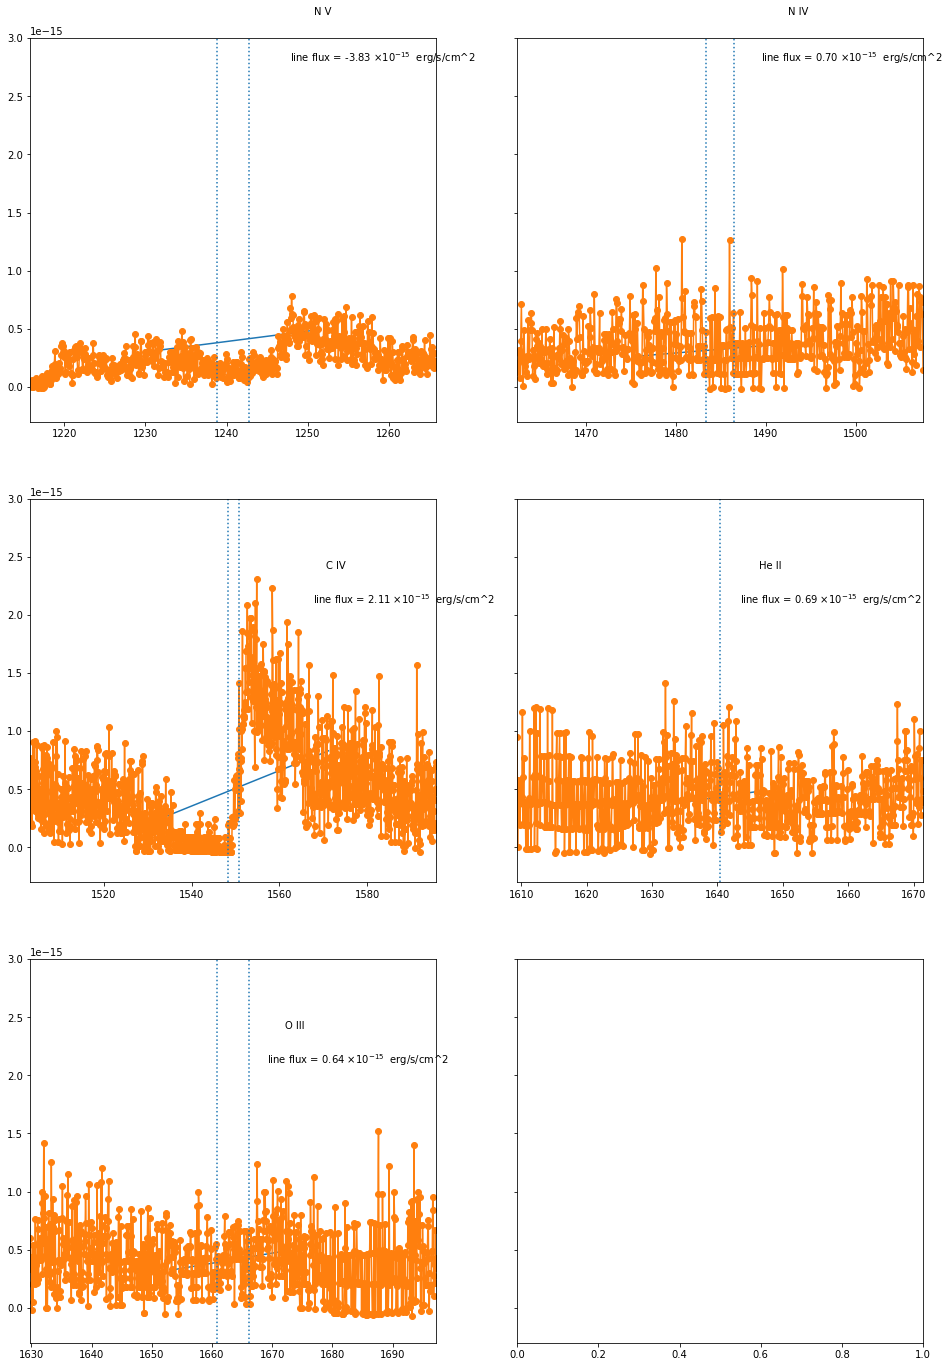

In [124]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)

(1451.862866956976, 2914.3984075592534)

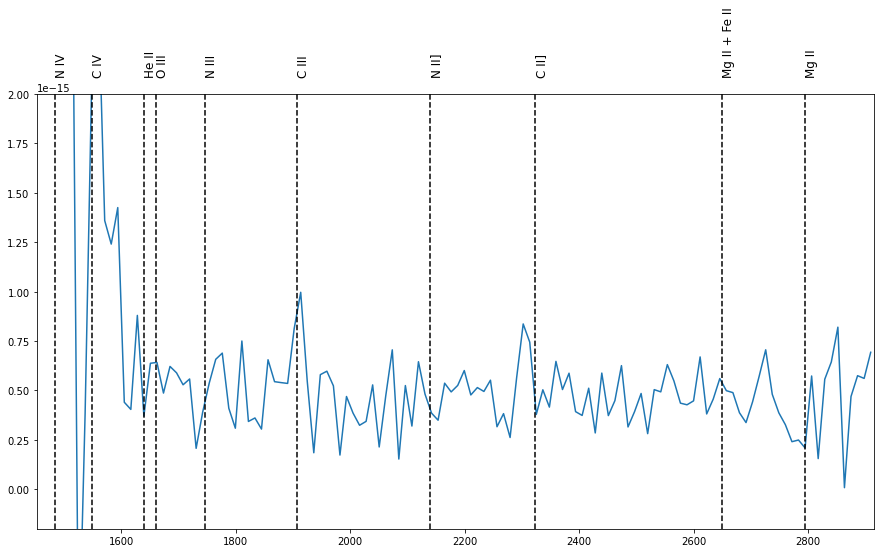

In [139]:
spec = fits.open('./reduced_spectra/2021csp/2021csp_d7NUV_x1d.fits')
z = z_dict['2021csp']
ebv = 0.028
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
if len(wav)>1024:
    bin_size=8
    f_bin = np.zeros(int(len(wav)/bin_size))
    wav_bin = np.zeros(int(len(wav)/bin_size))
    for i in range(int(len(wav)/bin_size)):
        wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
        f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])

plt.plot(wav_bin, f_bin)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-15)
plt.xlim(min(wav), max(wav))

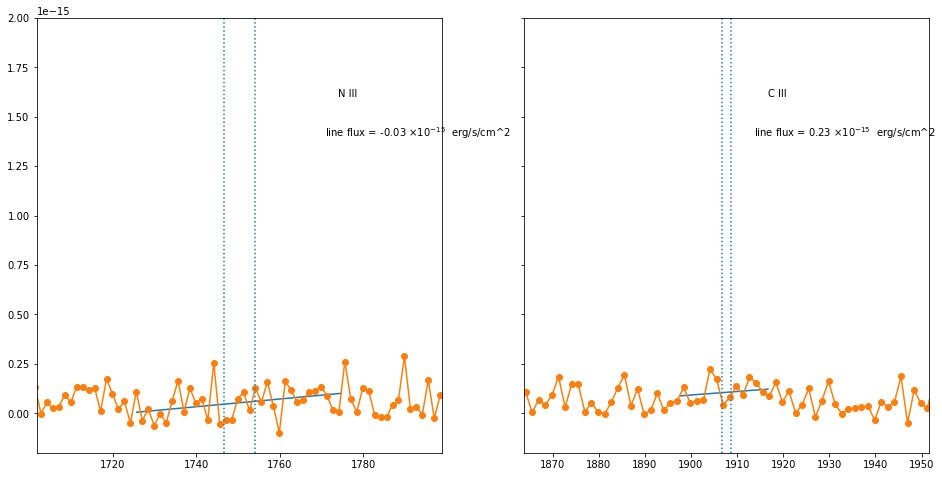

In [140]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 20
emflux = plot_region(axes[0], wav, flux, [ 1746.8,1754.0], linename = 'N III', bound = bound, 
                     xlim =25, ylim = 2e-15)

bound = 8
emflux = plot_region(axes[1], wav, flux, [ 1906.7, 1908.7], linename = 'C III', bound = bound, 
                     xlim =35, ylim = 2e-15)

(948.9253154739968, 2158.4311547543293)

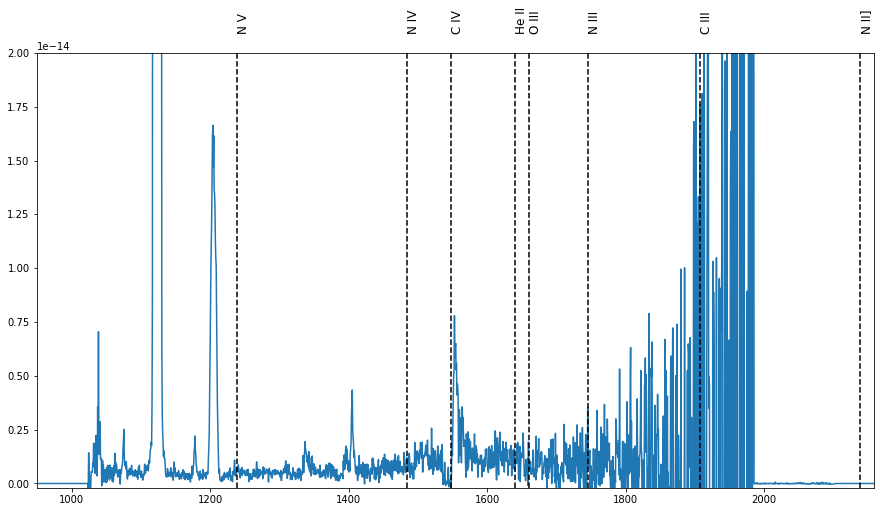

In [141]:
spec = fits.open('./reduced_spectra/2021csp/2021csp_d13FUV.fits')
z = z_dict['2021csp']
ebv = 0.028
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
bin_size=8
f_bin = np.zeros(int(len(wav)/bin_size))
wav_bin = np.zeros(int(len(wav)/bin_size))
for i in range(int(len(wav)/bin_size)):
    wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
    f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])

plt.plot(wav_bin, f_bin)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-14,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-14)
plt.xlim(min(wav), max(wav))

7.18506660471882e-16
3.115075898313889e-16 5.497192761730391e-16
1.6155533034971257e-15 6.802329698935266e-15
-6.667058991873441e-16 -3.6365776319309675e-15


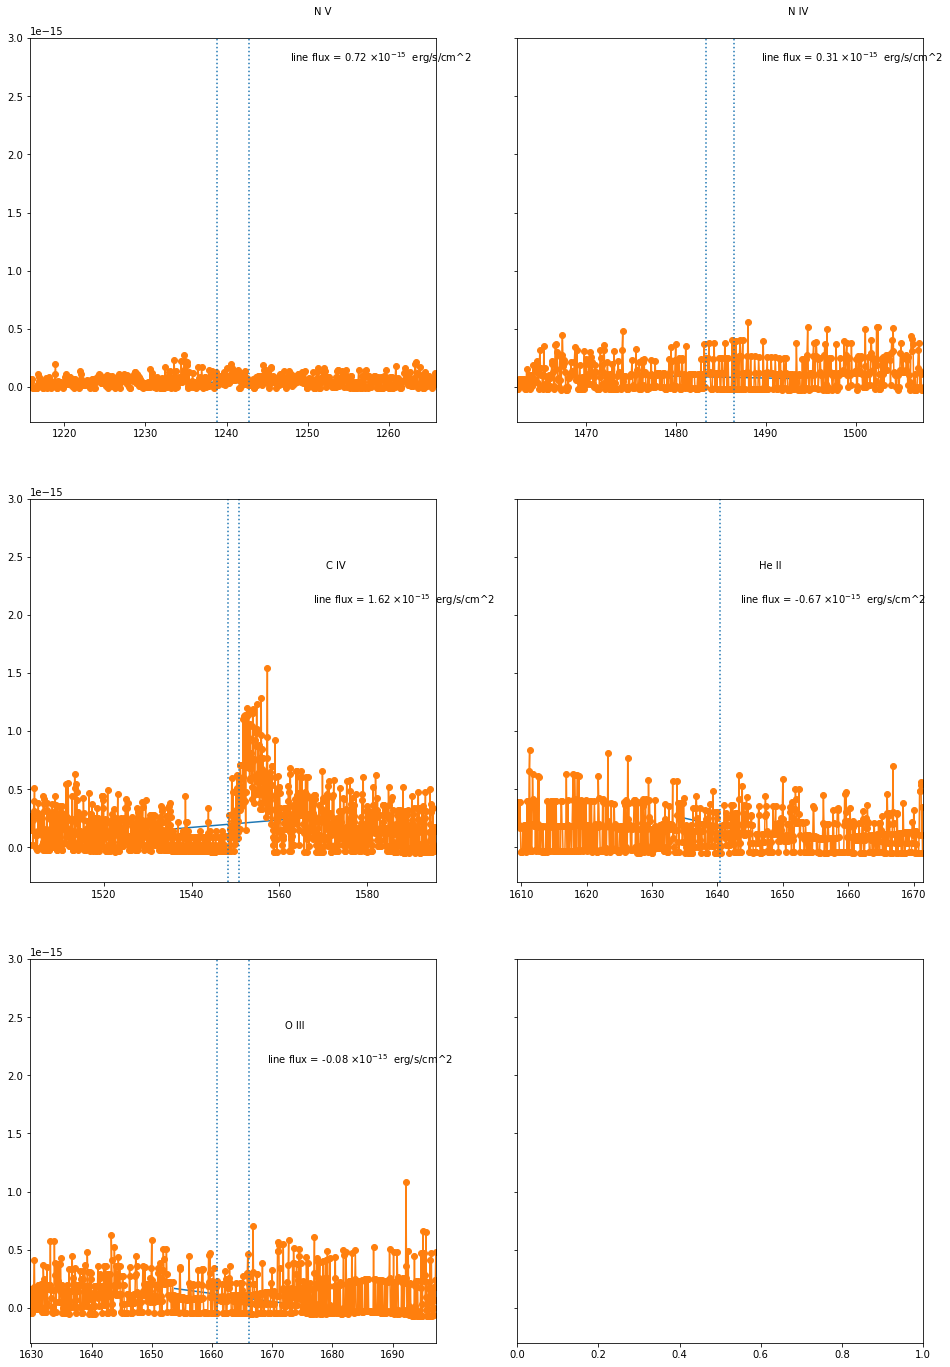

In [142]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)

## 2020nxt

(1095.732635981387, 1676.8613420615304)

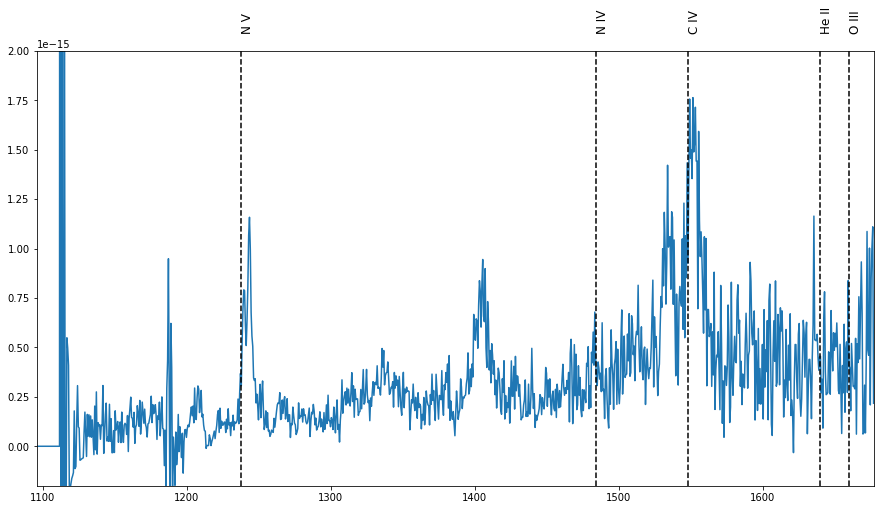

In [148]:
spec = fits.open('./reduced_spectra/2020nxt/2020nxt_d18FUV.fits')
z = z_dict['2020nxt']
ebv = 0.068
a_v = 3.1*ebv

wav = spec[1].data['WAVELENGTH'][0]/(1+z)
flux = spec[1].data['FLUX'][0]

plt.figure(figsize=(15, 8))
if len(wav)>1024:
    bin_size=8
    f_bin = np.zeros(int(len(wav)/bin_size))
    wav_bin = np.zeros(int(len(wav)/bin_size))
    for i in range(int(len(wav)/bin_size)):
        wav_bin[i] = np.average(wav[i*bin_size:i*bin_size+bin_size])
        f_bin[i] = np.sum(flux[i*bin_size:i*bin_size+bin_size])
else:
    plt.plot(wav, flux)

xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    if xcoords[i]<max(wav) and xcoords[i]>min(wav):
        plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
        plt.text(xcoords[i],2.1e-15,names[i],rotation=90,fontsize=12)

plt.ylim(-2e-16, 2e-15)
plt.xlim(min(wav), max(wav))

9.352101836142613e-15
1.8000598526832113e-15 3.176576210617431e-15
2.632091237118194e-14 1.1082489419445028e-13
1.7579898807759991e-16 9.589035713323632e-16


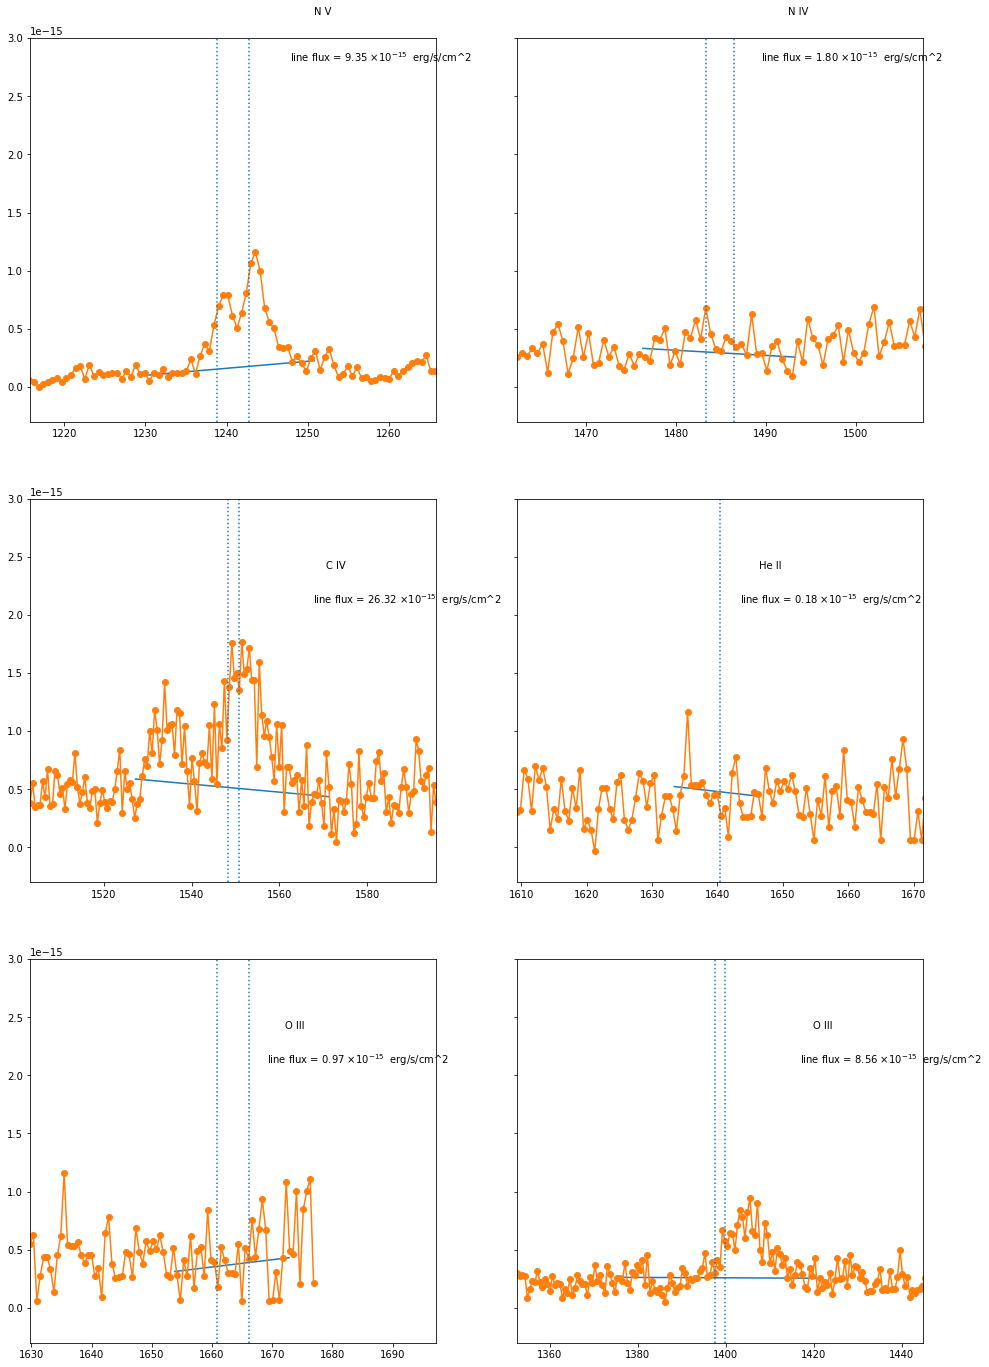

In [152]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 8*nrows), sharey = True)

bound = 8
emflux = plot_region(axes[0,0], wav, flux, [1238.8, 1242.8], linename = 'N V', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux)

bound = 6
emflux = plot_region(axes[0,1], wav, flux, [ 1483.3, 1486.5], linename = 'N IV', bound = bound, 
                     xlim =15, ylim = 4e-15)
print(emflux,emflux*4.8/2.72)

bound = 20
emflux = plot_region(axes[1,0], wav, flux, [1548.2, 1550.7], linename = 'C IV', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/1.14)

bound = 6
emflux = plot_region(axes[1,1], wav, flux, [1640.4], linename = 'He II', bound = bound, 
                     xlim =25, ylim = 3e-15)
print(emflux,emflux*4.8/0.88)

bound = 6
emflux = plot_region(axes[2,0], wav, flux, [1660.8, 1666.2], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)


bound = 20
emflux = plot_region(axes[2,1], wav, flux, [1397.61, 1399.8], linename = 'O III', bound = bound, 
                     xlim =25, ylim = 3e-15)
#print(emflux*4.8/0.88)

# notes:
#### 2021csp: complicated line structure alike p cygni profile, need to think about how to deal with it
